## Random Forest Prediction Model

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn import preprocessing, pipeline, metrics, model_selection
from sklearn.model_selection import GridSearchCV

pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100
sns.set_style("white")
%matplotlib inline

In [14]:
# read input 
full_concat_df = pd.read_csv("df_to_RF_model.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (130,131,132,135,136,137,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
#check 
full_concat_df[full_concat_df['table']=='a'].issue_d_year.value_counts()

2011    3232
Name: issue_d_year, dtype: int64

In [16]:
full_concat_df[full_concat_df['table']=='b'].issue_d_year.value_counts()

2013    3354
Name: issue_d_year, dtype: int64

### Encode loan_status as target

In [17]:
full_concat_df['target'] = full_concat_df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

In [18]:
full_concat_df['target'].value_counts()

0    5494
1    1092
Name: target, dtype: int64

In [19]:
encode_vars = ['tax_liens_le', 'home_ownership_le','verification_status_le','emp_length_impute_num', 
               'emp_title_truncated_impute_le','zip_code_truncated_le','term_encode', 'purpose_le']

num_vars = ['pub_rec_bankruptcies','dti','loan_amnt', 'annual_inc' ,'loan_income_ratio','fico_range_low','fico_range_high']





In [20]:
predict_features = num_vars + encode_vars

### Encode loan_status as target

In [230]:
full_concat_df['target'].value_counts()

0    5494
1    1092
Name: target, dtype: int64

In [20]:
predict_features = num_vars + encode_vars

### Random Forest Model Prediction and Performance Evaluation 

In [134]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
np.random.seed(4684)

#split into train and test to avoid overfitting
train_df = full_concat_df
# train_df = full_concat_df

X_train, X_test, y_train, y_test = train_test_split(full_concat_df[predict_features], full_concat_df['target'], stratify=full_concat_df['target'], test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced',oob_score=True)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# evaluate model
scores = cross_validate(rf, X_test, y_test, scoring=['recall','f1','roc_auc'], cv=cv, n_jobs=-1)
rf.fit(X_train,y_train)



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [135]:
# summarize performance
for k,v in scores.items():
    print(f" {k}: values: {v}, mean val {np.mean(v)}, std val: {np.std(v)}\n")

 fit_time: values: [0.42907953 0.42590046 0.42640924 0.42348695 0.43278313 0.42124438
 0.42140245 0.42492318 0.25827146 0.25420046], mean val 0.3917701244354248, std val: 0.06785131037699989

 score_time: values: [0.0480299  0.04714441 0.04810905 0.04523849 0.04845834 0.04763794
 0.0468049  0.04874754 0.02559805 0.02578115], mean val 0.04315497875213623, std val: 0.008783399895748802

 test_recall: values: [0.         0.02272727 0.04545455 0.         0.04545455 0.
 0.         0.         0.02325581 0.        ], mean val 0.013689217758985201, std val: 0.018208916455101382

 test_f1: values: [0.         0.04347826 0.08163265 0.         0.08510638 0.
 0.         0.         0.04444444 0.        ], mean val 0.025466174135395758, std val: 0.03359671714440216

 test_roc_auc: values: [0.69705579 0.69741736 0.68920455 0.57605708 0.70703611 0.64669421
 0.66404959 0.68155992 0.74910148 0.60351806], mean val 0.6711694139182084, std val: 0.048399280221980805



Confusion matrix

In [223]:
y_predict = rf.predict(X_test)
confusion_matrix(y_test, y_predict)
pd_confusion_matrix = pd.DataFrame(data = confusion_matrix(y_test, y_predict), columns=['Predicted Not charge-off', 'Predicted Charge-off'], index=['Not Chargeoff', 'Charge-off'])
pd_confusion_matrix

,Predicted Not charge-off,Predicted Charge-off
Not Chargeoff,1091,8
Charge-off,217,2


Grid serach to find the optimal hyperparameters

In [113]:
# grid search
forest = RandomForestClassifier(class_weight='balanced',random_state=42)
param_grid = [
{'n_estimators': [10, 25,50,100],
  'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]
}
]
grid_search_forest = GridSearchCV(forest, param_grid, cv=5, scoring='recall')
grid_search_forest.fit(X_train, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                            

In [114]:
grid_search_forest.best_params_, grid_search_forest.best_score_

({'max_features': 'auto',
  'min_samples_leaf': 4,
  'min_samples_split': 10,
  'n_estimators': 10},
 0.22564203612479478)

Use best parameters found by grid search for prediction

In [149]:
grid_search_best_rf = RandomForestClassifier(class_weight='balanced',n_estimators=100, min_samples_leaf=4,min_samples_split=10,random_state=42)
grid_search_best_rf.fit(X_train,y_train)



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

roc_auc score 

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.653


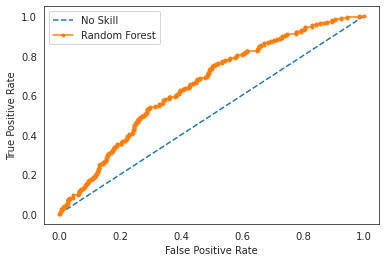

In [226]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
# predict probabilities
rf_predict_prob = grid_search_best_rf.predict_proba(X_test)
# keep probabilities for the positive outcome only
rf_probs = rf_predict_prob[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (rf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
# plot the roc curve for the mode
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

gini coefficient and kolmogorov-smirnov are common used in credit-risk industry

In [153]:
y_hat_test_proba = grid_search_best_rf.predict_proba(X_test)

In [154]:
y_hat_test_proba_char_off = y_hat_test_proba[:,1]

In [155]:
df_test_y = pd.DataFrame(y_test)
df_test_y.reset_index(drop = True, inplace = True)

In [157]:
df_t_test_prob = pd.DataFrame(y_hat_test_proba_char_off)

In [158]:
df_actual_predicted_probs = pd.concat([df_test_y, df_t_test_prob], axis = 1,ignore_index=False)


In [160]:
df_actual_predicted_probs.index = X_test.index

In [161]:

df_actual_predicted_probs.columns = ['loan_data_targets_test', 'y_hat_test_proba']

In [208]:
df_probs_threashold = df_actual_predicted_probs.sort_values('y_hat_test_proba',ascending=False)


In [210]:
df_probs_threashold = df_probs_threashold.reset_index(drop=True)

In [212]:
# check the prob_threashold of charge-off

df_probs_threashold['Cumulative N Population'] = df_probs_threashold.index + 1
# We calculate the cumulative number of all observations.
# We use the new index for that. Since indexing in ython starts from 0, we add 1 to each index.
df_probs_threashold['Cumulative N Charge-off'] = df_probs_threashold['loan_data_targets_test'].cumsum()
# We calculate cumulative number of 'good', which is the cumulative sum of the column with actual observations.
df_probs_threashold['Cumulative N Good'] = df_probs_threashold['Cumulative N Population'] - df_probs_threashold['loan_data_targets_test'].cumsum()



In [213]:
df_probs_threashold['Cumulative Perc Population'] = df_probs_threashold['Cumulative N Population'] / (df_probs_threashold.shape[0])
# We calculate the cumulative percentage of all observations.
df_probs_threashold['Cumulative Perc Charge-off'] = df_probs_threashold['Cumulative N Charge-off'] / df_probs_threashold['loan_data_targets_test'].sum()
# We calculate cumulative percentage of 'good'.
df_probs_threashold['Cumulative Perc Good'] = df_probs_threashold['Cumulative N Good'] / (df_probs_threashold.shape[0] - df_probs_threashold['loan_data_targets_test'].sum())
# We calculate the cumulative percentage of 'bad'.

Text(0.5, 1.0, 'Gini')

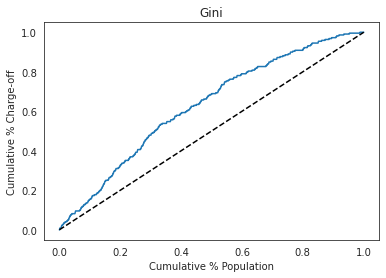

In [214]:
# Plot Gini
plt.plot(df_probs_threashold['Cumulative Perc Population'], df_probs_threashold['Cumulative Perc Charge-off'])
# We plot the cumulative percentage of all along the x-axis and the cumulative percentage 'good' along the y-axis,
# thus plotting the Gini curve.
plt.plot(df_probs_threashold['Cumulative Perc Population'], df_probs_threashold['Cumulative Perc Population'], linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('Cumulative % Population')
# We name the x-axis "Cumulative % Population".
plt.ylabel('Cumulative % Charge-off')
# We name the y-axis "Cumulative % Bad".
plt.title('Gini')
# We name the graph "Gini".

In [225]:
gini_coef = 2*rf_auc-1
gini_coef

0.3052879122157546

Text(0.5, 1.0, 'Kolmogorov-Smirnov')

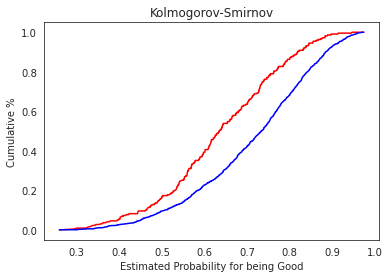

In [216]:
# Plot KS
plt.plot(1-df_probs_threashold['y_hat_test_proba'], df_probs_threashold['Cumulative Perc Charge-off'], color = 'r')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'charge-off' along the y-axis,
# colored in red.
plt.plot(1-df_probs_threashold['y_hat_test_proba'], df_probs_threashold['Cumulative Perc Good'], color = 'b')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'good' along the y-axis,
# colored in red.
plt.xlabel('Estimated Probability for being Good')
# We name the x-axis "Estimated Probability for being Good".
plt.ylabel('Cumulative %')
# We name the y-axis "Cumulative %".
plt.title('Kolmogorov-Smirnov')
# We name the graph "Kolmogorov-Smirnov".

In [220]:
KS = max(df_probs_threashold['Cumulative Perc Charge-off'] - df_probs_threashold['Cumulative Perc Good'])
KS

0.24658365222015854

### The Random Forest Classifie Performance Summeries
- Random forest model has roc_ruc 0.653
- The Gini coefficient is 0.305
- The max diff in Kolmogrov-Smirnov curve is 0.247